In [ ]:
!kaggle datasets download -d hojjatk/mnist-dataset

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
100% 22.0M/22.0M [00:00<00:00, 122MB/s] 
100% 22.0M/22.0M [00:00<00:00, 112MB/s]


In [ ]:
!unzip mnist-dataset.zip

Archive:  mnist-dataset.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import struct
from array import array
import random

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

training_images_filepath = 'train-images.idx3-ubyte'
training_labels_filepath = 'train-labels.idx1-ubyte'
test_images_filepath = 't10k-images.idx3-ubyte'
test_labels_filepath = 't10k-labels.idx1-ubyte'

mnist_loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)

(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)



Step1: Filtering Data for 0,1,2 and Normalization

In [ ]:
train_filter = np.isin(y_train, [0, 1, 2])
test_filter = np.isin(y_test, [0, 1, 2])

x_train_filtered = x_train[train_filter]
y_train_filtered = y_train[train_filter]
x_test_filtered = x_test[test_filter]
y_test_filtered = y_test[test_filter]

def random_sample(x_data, y_data, class_label, num_samples):
    class_indices = np.where(y_data == class_label)[0]
    idx = random.sample(list(class_indices), num_samples)
    return x_data[idx], y_data[idx]

train_samples = []
test_samples = []

for class_label in [0, 1, 2]:
    x_train_class, y_train_class = random_sample(x_train_filtered, y_train_filtered, class_label, 100)
    x_test_class, y_test_class = random_sample(x_test_filtered, y_test_filtered, class_label, 100)

    train_samples.append((x_train_class, y_train_class))
    test_samples.append((x_test_class, y_test_class))

x_train_sampled = np.concatenate([sample[0] for sample in train_samples], axis=0)
y_train_sampled = np.concatenate([sample[1] for sample in train_samples], axis=0)
x_test_sampled = np.concatenate([sample[0] for sample in test_samples], axis=0)
y_test_sampled = np.concatenate([sample[1] for sample in test_samples], axis=0)

print(f'Train set shape: {x_train_sampled.shape}, {y_train_sampled.shape}')
print(f'Test set shape: {x_test_sampled.shape}, {y_test_sampled.shape}')

def preprocess_images(images):

    feature_vectors = images.reshape(images.shape[0], -1)
    feature_vectors = feature_vectors / 255.0

    return feature_vectors

x_train_normalized = preprocess_images(x_train_sampled)
x_test_normalized = preprocess_images(x_test_sampled)

print(f'Normalized train set shape: {x_train_normalized.shape}')
print(f'Normalized test set shape: {x_test_normalized.shape}')


Train set shape: (300, 28, 28), (300,)
Test set shape: (300, 28, 28), (300,)
Normalized train set shape: (300, 784)
Normalized test set shape: (300, 784)


Step 2: Estimating MLE mean and covariance


In [ ]:
def MLE(x_data, y_data, class_label):

    class_data = x_data[y_data == class_label]
    n = class_data.shape[0]
    mean = np.mean(class_data, axis=0)

    covariance_matrix = np.zeros((class_data.shape[1], class_data.shape[1]))
    for i in range(n):
        diff = class_data[i] - mean
        covariance_matrix += np.outer(diff, diff)

    covariance_matrix /= (n - 1)
    return mean, covariance_matrix


mean_covariances = {}
for class_label in [0, 1, 2]:
    mean, cov = MLE(x_train_normalized, y_train_sampled, class_label)
    mean_covariances[class_label] = (mean, cov)
    print(f'Class {class_label}:')
    print(f'Mean:\n{mean}\n')
    print(f'Covariance Matrix:\n{cov}\n')


Class 0:
Mean:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000000

Fisher's Discriminant Analysis (FDA)

In [ ]:
import numpy as np

overall_mean = np.mean(x_train_normalized, axis=0, keepdims=True)

Sb = np.zeros((x_train_normalized.shape[1], x_train_normalized.shape[1]))
for class_label in [0, 1, 2]:
    class_data = x_train_normalized[y_train_sampled == class_label]
    class_mean = np.mean(class_data, axis=0, keepdims=True)

    Sb += class_data.shape[0] * np.dot((class_mean - overall_mean).T, (class_mean - overall_mean))

Sw = np.zeros((x_train_normalized.shape[1], x_train_normalized.shape[1]))
for class_label in [0, 1, 2]:
    class_data = x_train_normalized[y_train_sampled == class_label]
    class_mean = np.mean(class_data, axis=0, keepdims=True)
    centered_class_data = class_data - class_mean
    Sw += np.dot(centered_class_data.T, centered_class_data)

regularization_term = 1e-6 * np.eye(Sw.shape[0])
Sw += regularization_term

eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(Sw).dot(Sb))

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]
eigenvalues = eigenvalues[sorted_indices]

W = eigenvectors

print(f'Shape of W: {W.shape}')

Y_train_fda = np.dot(x_train_normalized, W)
print(f'Shape of Y_train_fda: {Y_train_fda.shape}')

Y_test_fda = np.dot(x_test_normalized, W)
print(f'Shape of set Y_test_fda: {Y_test_fda.shape}')


Shape of W: (784, 784)
Shape of Y_train_fda: (300, 784)
Shape of set Y_test_fda: (300, 784)


Applying FDA followed by LDA and QDA

In [ ]:
def calculate_mean_cov(x_data, y_data, regularization_term=1e-6):
    class_statistics = {}
    for class_label in np.unique(y_data):
        class_data = x_data[y_data == class_label]
        mu_c = np.mean(class_data, axis=0)
        covariance_matrix = np.zeros((class_data.shape[1], class_data.shape[1]))
        for i in range(class_data.shape[0]):
            diff = class_data[i] - mu_c
            covariance_matrix += np.outer(diff, diff)
        covariance_matrix /= (class_data.shape[0] - 1)

        # Add regularization term to the diagonal elements
        covariance_matrix += regularization_term * np.eye(covariance_matrix.shape[0])

        class_statistics[class_label] = (mu_c, covariance_matrix)
    return class_statistics

stats = calculate_mean_cov(Y_train_fda, y_train_sampled)


In [ ]:
def lda(x_data, class_data):
    predictions = []
    for x in x_data:
        best_class = None
        best_discriminant_value = -np.inf
        for class_label, (mean, cov) in class_data.items():
            discriminant_value = -0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), (x - mean))
            if discriminant_value > best_discriminant_value:
                best_discriminant_value = discriminant_value
                best_class = class_label
        predictions.append(best_class)
    return np.array(predictions)

y_train_pred_lda_reg = lda(Y_train_fda, stats)
y_test_pred_lda_reg = lda(Y_test_fda, stats)


In [ ]:
from sklearn.metrics import accuracy_score

lda_train_accuracy_reg = accuracy_score(y_train_sampled, y_train_pred_lda_reg)
lda_test_accuracy_reg = accuracy_score(y_test_sampled, y_test_pred_lda_reg)

print(f'LDA Train Accuracy: {lda_train_accuracy_reg * 100:.2f}%')
print(f'LDA Test Accuracy: {lda_test_accuracy_reg * 100:.2f}%')


LDA Train Accuracy: 100.00%
LDA Test Accuracy: 99.00%


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

W_fda = W[:, :2]

X_train_fda = np.dot(x_train_normalized, W_fda)
X_test_fda = np.dot(x_test_normalized, W_fda)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_fda, y_train_sampled)

y_train_pred_qda = qda.predict(X_train_fda)
y_test_pred_qda = qda.predict(X_test_fda)

qda_train_accuracy = accuracy_score(y_train_sampled, y_train_pred_qda)
qda_test_accuracy = accuracy_score(y_test_sampled, y_test_pred_qda)

print(f'QDA Train Accuracy: {qda_train_accuracy * 100:.2f}%')
print(f'QDA Test Accuracy: {qda_test_accuracy * 100:.2f}%')


QDA Train Accuracy: 97.67%
QDA Test Accuracy: 95.67%


Applying PCA with variance% = 95

In [ ]:
import numpy as np

def pca_with_variance(X, variance_threshold=0.95):

    mu = np.mean(X, axis=0, keepdims=True)


    Xc = X - mu


    N = X.shape[0]
    S = np.dot(Xc.T, Xc) / (N - 1)

    eigenvalues, eigenvectors = np.linalg.eigh(S)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    num_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
    U_p = eigenvectors[:, :num_components]

    Y = np.dot(Xc, U_p)

    return Y, U_p, mu

variance_threshold = 0.95
Y_train_pca, U_p, mu_pca = pca_with_variance(x_train_normalized, variance_threshold)
print(f'Shape of Y_train_pca: {Y_train_pca.shape}')

Shape of Y_train_pca: (300, 80)


In [ ]:
def transform_test_data_pca(X_test, mu, U_p):
    X_test_centered = X_test - mu
    Y_test_pca = np.dot(X_test_centered, U_p)
    return Y_test_pca

Y_test_pca = transform_test_data_pca(x_test_normalized, mu_pca, U_p)
print(f'Shape of Y_test_pca: {Y_test_pca.shape}')


Shape of Y_test_pca: (300, 80)


In [ ]:
stats = calculate_mean_cov(Y_train_pca, y_train_sampled)

In [ ]:
y_train_pred_lda = lda(Y_train_pca, stats)
y_test_pred_lda = lda(Y_test_pca, stats)

lda_train_accuracy = accuracy_score(y_train_sampled, y_train_pred_lda)
lda_test_accuracy = accuracy_score(y_test_sampled, y_test_pred_lda)

print(f'LDA Train Accuracy: {lda_train_accuracy * 100:.2f}%')
print(f'LDA Test Accuracy: {lda_test_accuracy * 100:.2f}%')



LDA Train Accuracy: 100.00%
LDA Test Accuracy: 90.00%


Applying PCA with 90% variance threshold

In [ ]:
variance_threshold = 0.90
Y_train_pca, U_p, mu_pca = pca_with_variance(x_train_normalized, variance_threshold)
print(f'Shape of Y_train_pca: {Y_train_pca.shape}')

def transform_test_data_pca(X_test, mu, U_p):
    X_test_centered = X_test - mu
    Y_test_pca = np.dot(X_test_centered, U_p)
    return Y_test_pca

Y_test_pca = transform_test_data_pca(x_test_normalized, mu_pca, U_p)
print(f'Shape of Y_test_pca: {Y_test_pca.shape}')

Shape of Y_train_pca: (300, 48)
Shape of Y_test_pca: (300, 48)


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

stats = calculate_mean_cov(Y_train_pca, y_train_sampled)
y_train_pred_lda = lda(Y_train_pca, stats)
y_test_pred_lda = lda(Y_test_pca, stats)

lda_train_accuracy = accuracy_score(y_train_sampled, y_train_pred_lda)
lda_test_accuracy = accuracy_score(y_test_sampled, y_test_pred_lda)

print(f'LDA Train Accuracy: {lda_train_accuracy * 100:.2f}%')
print(f'LDA Test Accuracy: {lda_test_accuracy * 100:.2f}%')



LDA Train Accuracy: 100.00%
LDA Test Accuracy: 93.33%


Taking only first 2 principal components for PCA

In [ ]:
def pca_first_2_components(X):
    mu = np.mean(X, axis=0, keepdims=True)

    Xc = X - mu
    N = X.shape[0]
    S = np.dot(Xc.T, Xc) / (N - 1)

    eigenvalues, eigenvectors = np.linalg.eigh(S)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    U_p = eigenvectors[:, :2]

    Y = np.dot(Xc, U_p)

    return Y, U_p, mu

Y_train_pca_2, U_p_2, mu_pca_2 = pca_first_2_components(x_train_normalized)
print(f'Shape of Y_train_pca_2: {Y_train_pca_2.shape}')

Y_test_pca_2 = transform_test_data_pca(x_test_normalized, mu_pca_2, U_p_2)
print(f'Shape of Y_test_pca_2: {Y_test_pca_2.shape}')


Shape of Y_train_pca_2: (300, 2)
Shape of Y_test_pca_2: (300, 2)


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

stats = calculate_mean_cov(Y_train_pca_2, y_train_sampled)
y_train_pred_lda = lda(Y_train_pca_2, stats)
y_test_pred_lda = lda(Y_test_pca_2, stats)

lda_train_accuracy = accuracy_score(y_train_sampled, y_train_pred_lda)
lda_test_accuracy = accuracy_score(y_test_sampled, y_test_pred_lda)

print(f'LDA Train Accuracy: {lda_train_accuracy * 100:.2f}%')
print(f'LDA Test Accuracy: {lda_test_accuracy * 100:.2f}%')



LDA Train Accuracy: 93.67%
LDA Test Accuracy: 93.67%


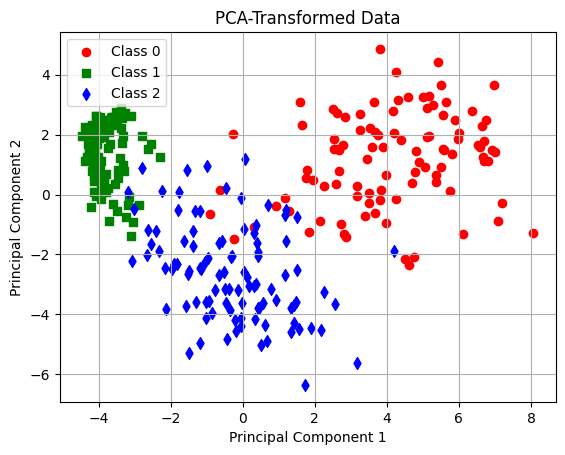

In [ ]:
import matplotlib.pyplot as plt

def plot_2d_data(Y, labels, title, x_label, y_label):
    unique_labels = np.unique(labels)
    markers = ['o', 's', 'd']
    colors = ['r', 'g', 'b']

    for i, label in enumerate(unique_labels):
        plt.scatter(Y[labels == label, 0], Y[labels == label, 1],
                    c=colors[i], marker=markers[i], label=f'Class {label}')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_2d_data(Y_train_pca, y_train_sampled, 'PCA-Transformed', 'Principal Component 1', 'Principal Component 2')


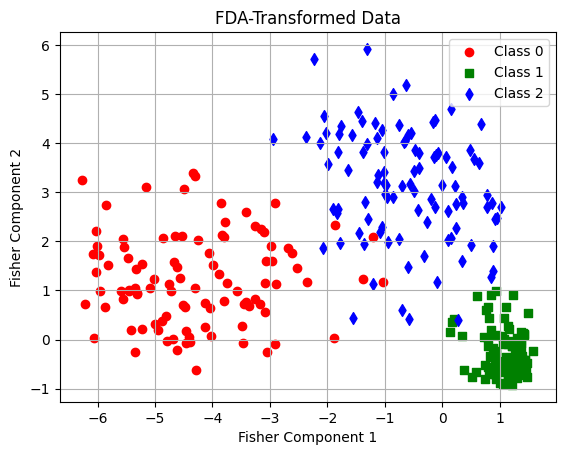

In [ ]:

plot_2d_data(Y_train_fda, y_train_sampled, 'FDA-Transformed', 'Fisher Component 1', 'Fisher Component 2')
